# Neural Style Transfer

This largely follows <a href="https://www.tensorflow.org/tutorials/generative/style_transfer">this</a> tutorial.

## Imports

In [1]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub

## Helper Functions

In [16]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/num_locations

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

def load_image(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def plot_training_metrics(history):
    '''
    Takes a history object generated along with model training and plots
    selected training metrics.
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('MAE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.suptitle('Model Training')
    plt.legend()
    plt.show()

def save_best_model(model, test_ds, filename):
    '''
    Compares the performance of a saved model stored at filename with the provided model on
    the provided test dataset. If the provided model performs better than the saved model
    the provided model is saved to filename, overwriting the previously saved model. If
    no saved model is present at filename then the provided model is saved to filename
    '''
    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['loss'] < saved_model_metrics['loss']:
            model.save(filename)
    else:
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds)
        model.save(filename)

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

## Downloading Images

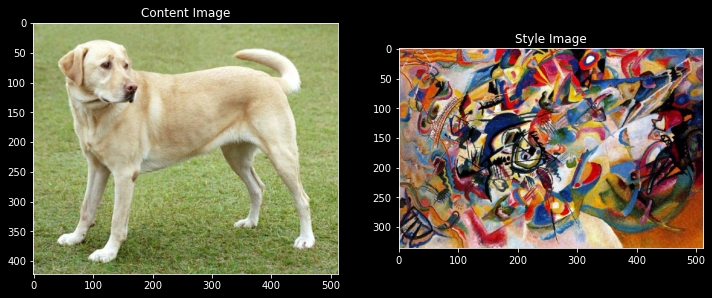

In [5]:
content_image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_image_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_image = load_image(content_image_path)
style_image = load_image(style_image_path)
fig = plt.figure(figsize=(12, 16))
plt.subplot(1, 2, 1)
imshow(content_image, title='Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, title='Style Image')

## Using a Pretrained Style Transfer Model

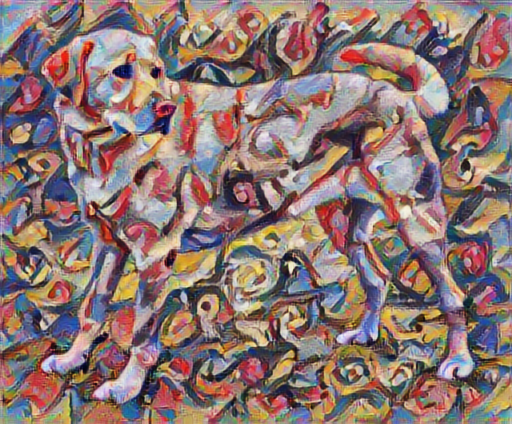

In [6]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Using a Pretrained Image Classifier to Define Style and Content Representations

Testing that it is working correctly

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19()
prediction_probabilities = vgg(x)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
for number, class_name, prob in predicted_top_5:
    print(f'({class_name}, {prob})')

vgg = tf.keras.applications.VGG19(include_top=False)
for layer in vgg.layers:
    print(layer.name)

(Labrador_retriever, 0.49317100644111633)
(golden_retriever, 0.2366528958082199)
(kuvasz, 0.03635750710964203)
(Chesapeake_Bay_retriever, 0.02418280951678753)
(Greater_Swiss_Mountain_dog, 0.018646100535988808)
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Assigning content and style layers

In [8]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Buliding a model to output the appropriate layers

In [11]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False)
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



### Defining the Style Representation

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        '''
        Expects float input in [0, 1]
        '''
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.492
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.36
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


### Running Gradient on the Image

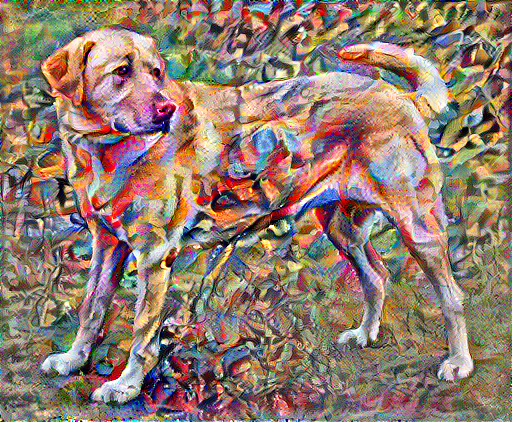

In [18]:
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

content_weight = 1e4
style_weight = 1e-2

def style_content_loss(outputs):
    content_outputs = outputs['content']
    style_outputs = outputs['style']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight/num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight/num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

epochs = 10
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

### Implementing a Total Variation Loss to Reduce High Frequency Artifacts

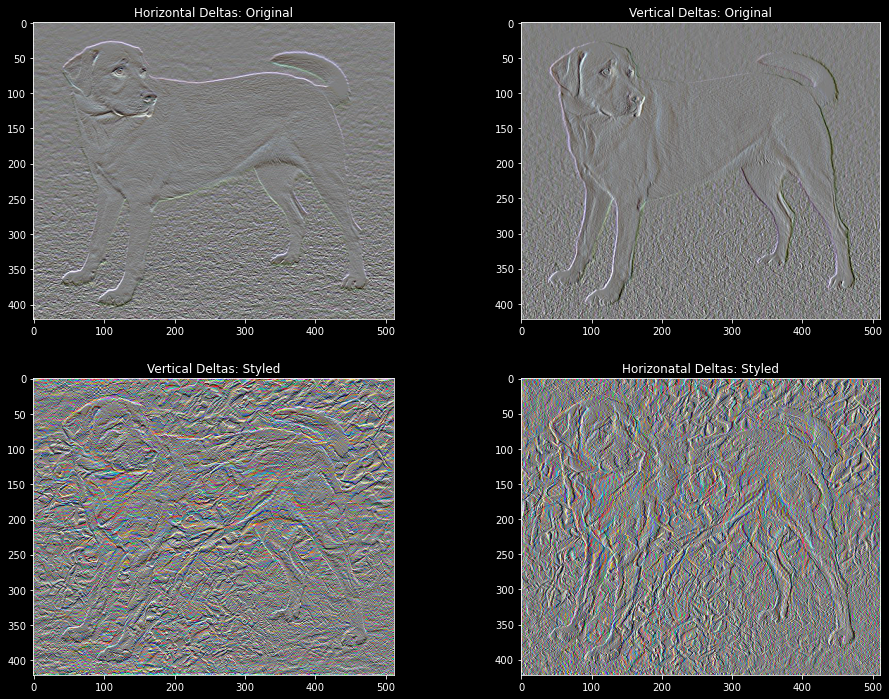

In [19]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), 'Horizontal Deltas: Original')
plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), 'Vertical Deltas: Original')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), 'Vertical Deltas: Styled')
plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), 'Horizonatal Deltas: Styled')

def total_variation_loss(image):
    '''
    This is a sample implementation, tensorflow contains an official implementation as tf.image.total_variation
    '''
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

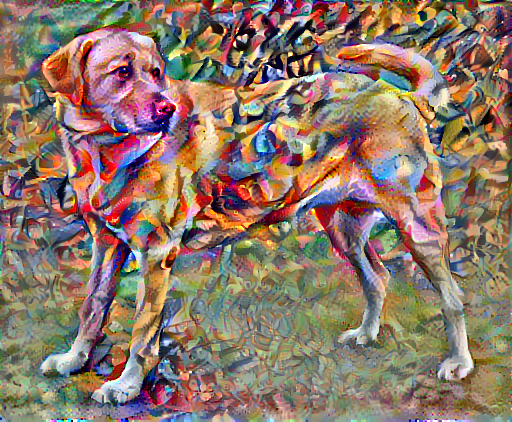

Train step: 1000


In [21]:
total_variation_weight = 30

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

image = tf.Variable(content_image)

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

## Saving the Output Image

In [23]:
filename = 'images\\stylized_dog.png'
tensor_to_image(image).save(filename)